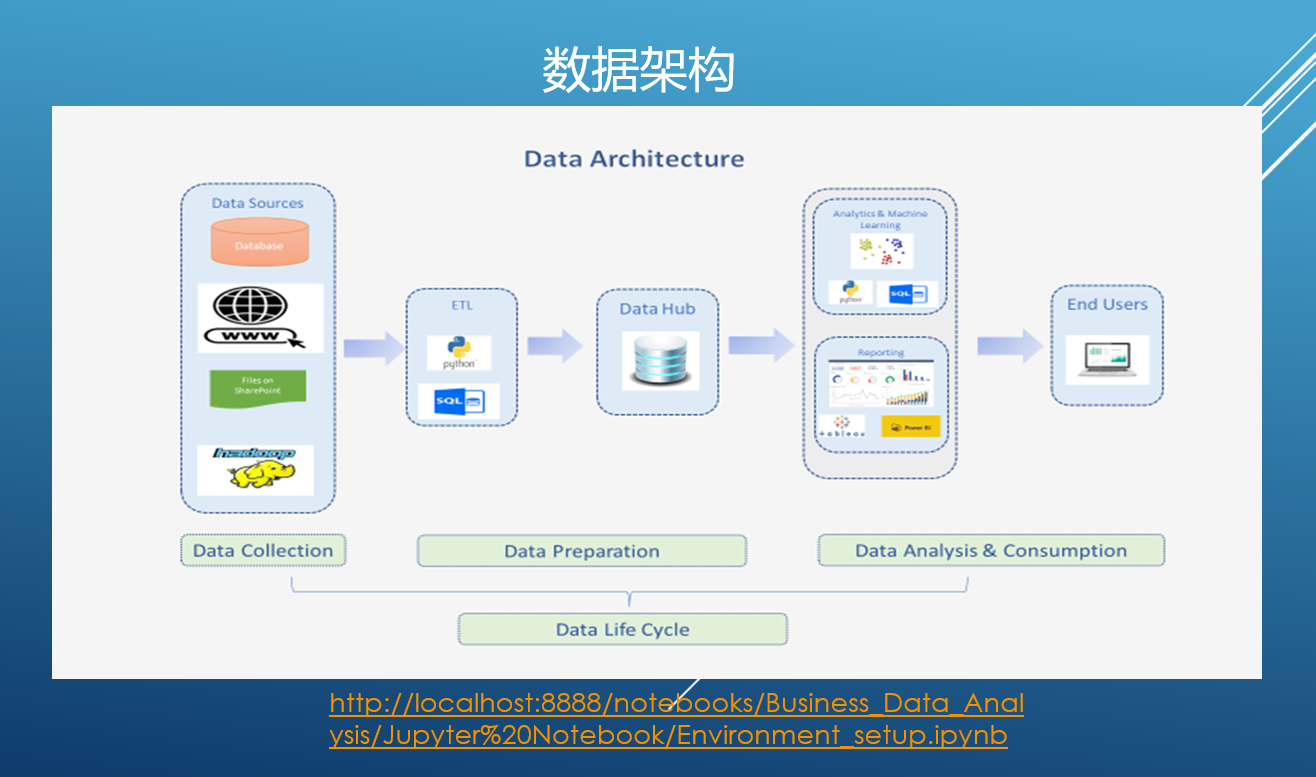

## 1.Import python packages

In [20]:
import pandas as pd
import numpy as np
import os

path=os.environ['USERPROFILE']+r'/OneDrive/BDA2/'

file_path=path
# file_path=os.environ['USERPROFILE']+'/Business_Data_Analysis/'

## 2.Establish connection to database

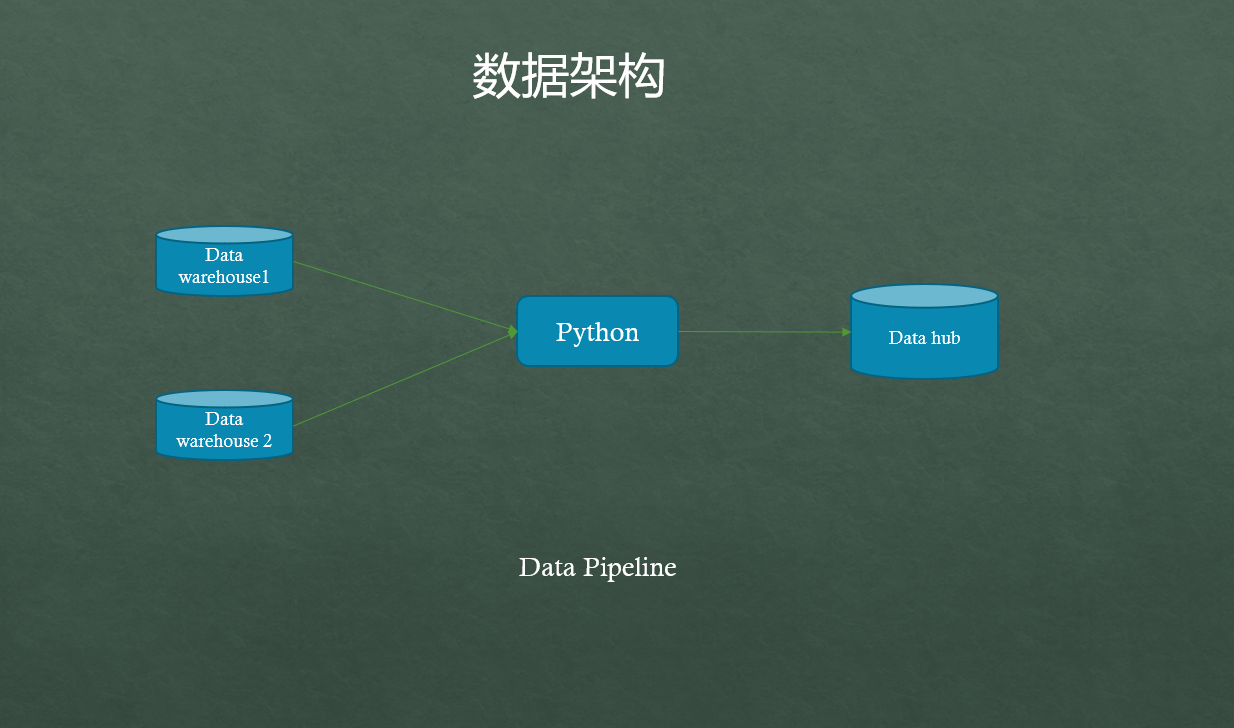

# Data Collection & Preparation

In [21]:
import pyodbc
import urllib
import sqlalchemy

'''sources databases'''
params_p = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=DataWarehouse1;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_p = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_p))


params_s = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=DataWarehouse2;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_s = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_s))



'''destination databases'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

## 3.back up your data

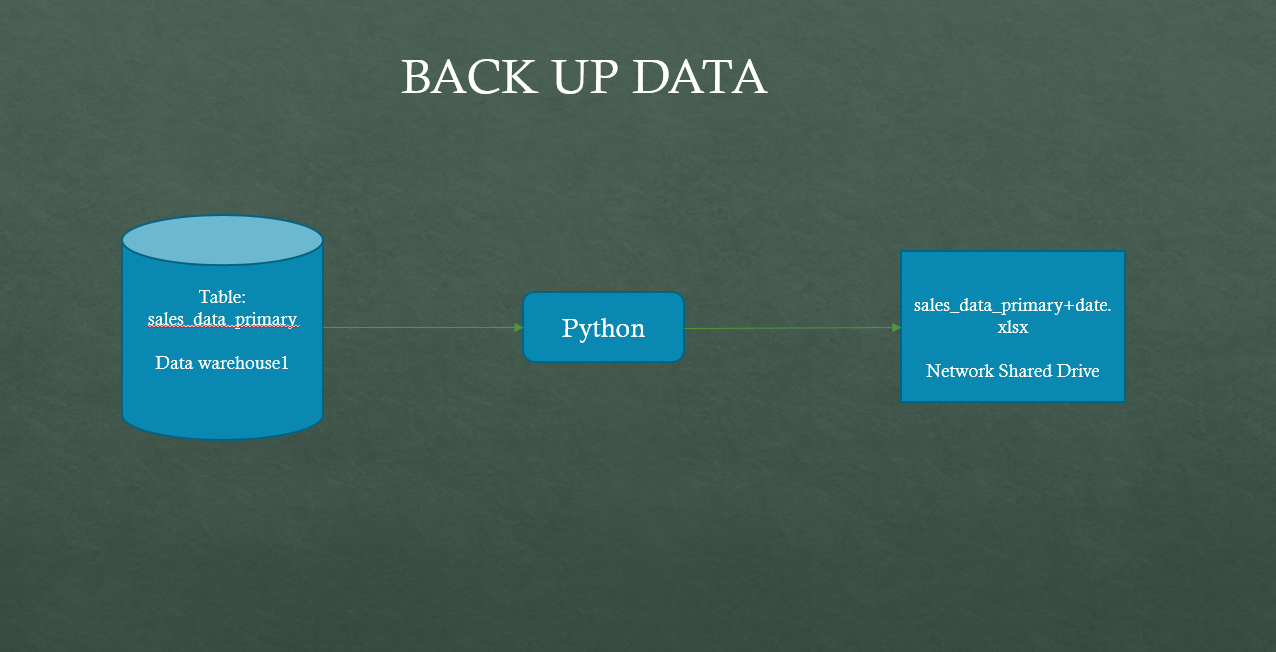

In [22]:
'''get historical data from source database'''
df_sales_p=pd.read_sql_table('user_table',engine_p)

In [44]:
from datetime import datetime

dateTimeObj = datetime.now()

timestampStr = dateTimeObj.strftime("%d-%m-%Y-%H-%M-%S")

print('Current Timestamp : ', timestampStr)

Current Timestamp :  09-07-2023-20-55-31


In [46]:
df_sales_p.to_csv(file_path+'data/user_table_backup_'+timestampStr+'.csv',index=True)

In [18]:
from datetime import datetime
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%m-%Y-%H-%M-%S")
print('Current Timestamp : ', timestampStr)

Current Timestamp :  04-12-2022-16-06-58


## 4.ETL data to datahub

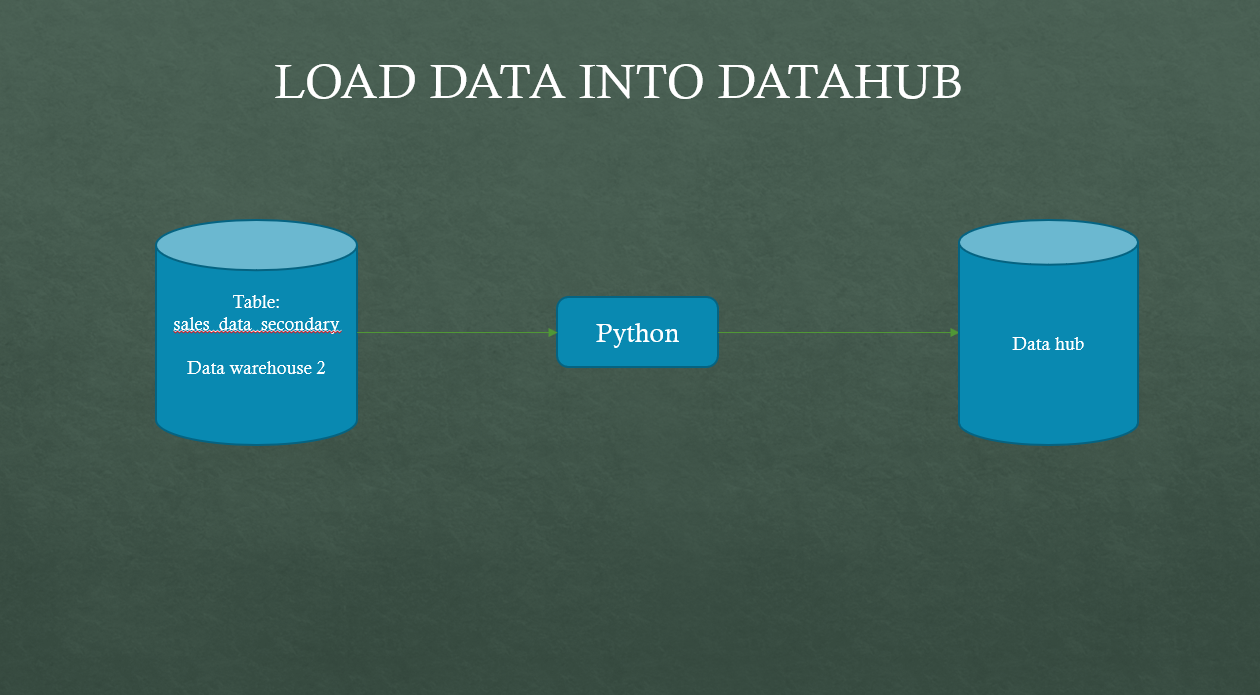

In [19]:
df_sales_s=pd.read_sql('home_page_table',engine_s)

df_sales_s.to_sql("home_page_table",engine_datahub,if_exists='replace',index=False)

## a. Append new data to historical data

### i. Option 1: using python

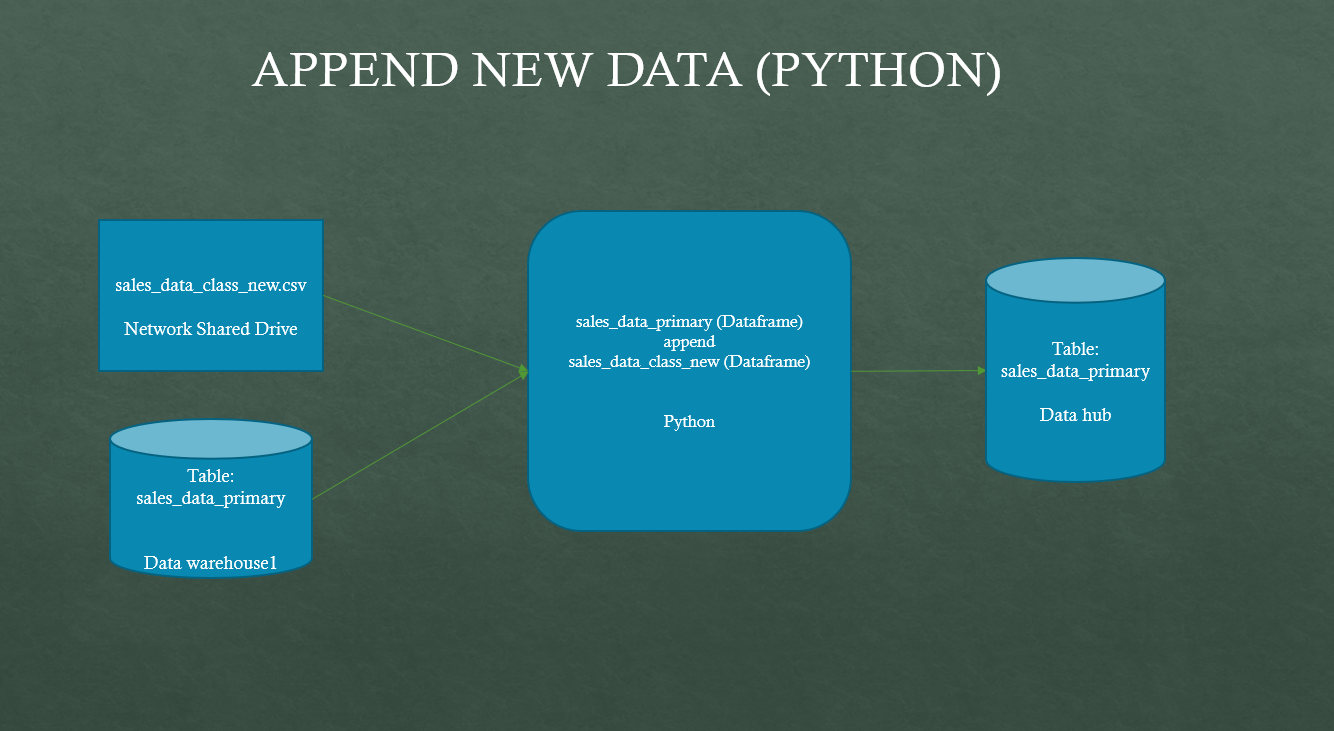

In [20]:
from datetime import datetime


#get new data

df_sales_p_new=pd.read_csv(file_path+'data/user_table_new.csv',index_col=False)


In [21]:
df_sales_p_new

541196  4/30/2015  Desktop    Male
0    813987  4/30/2015   Mobile    Male
1    173145  4/30/2015   Mobile  Female
2    244299  4/30/2015  Desktop    Male
3     53797  4/30/2015  Desktop  Female
4     90712  4/30/2015  Desktop    Male
..      ...        ...      ...     ...
148  455845  4/30/2015  Desktop    Male
149   30699  4/30/2015  Desktop    Male
150  599710  4/30/2015   Mobile    Male
151  622751  4/30/2015   Mobile  Female
152   44616  4/30/2015  Desktop  Female

[153 rows x 4 columns]

In [22]:
'''get historical data from source database'''
df_sales_p=pd.read_sql_table('user_table',engine_p)
df_sales_p.shape

(90400, 2)

In [23]:
'''append new data to historical data'''
df_sales_p=pd.concat([df_sales_p,df_sales_p_new])
df_sales_p.shape

(90553, 6)

In [24]:
help(pd.concat)

Help on function concat in module pandas.core.reshape.concat:

concat(objs: 'Iterable[NDFrame] | Mapping[Hashable, NDFrame]', axis=0, join='outer', ignore_index: 'bool' = False, keys=None, levels=None, names=None, verify_integrity: 'bool' = False, sort: 'bool' = False, copy: 'bool' = True) -> 'FrameOrSeriesUnion'
    Concatenate pandas objects along a particular axis with optional set logic
    along the other axes.
    
    Can also add a layer of hierarchical indexing on the concatenation axis,
    which may be useful if the labels are the same (or overlapping) on
    the passed axis number.
    
    Parameters
    ----------
    objs : a sequence or mapping of Series or DataFrame objects
        If a mapping is passed, the sorted keys will be used as the `keys`
        argument, unless it is passed, in which case the values will be
        selected (see below). Any None objects will be dropped silently unless
        they are all None in which case a ValueError will be raised.
    a

In [25]:
'''drop duplicate'''
df_sales_p.drop_duplicates(keep='first', inplace=True)

df_sales_p

user_id       page    541196  4/30/2015  Desktop    Male
0    313593.0  home_page       NaN        NaN      NaN     NaN
1    468315.0  home_page       NaN        NaN      NaN     NaN
2    264005.0  home_page       NaN        NaN      NaN     NaN
3    290784.0  home_page       NaN        NaN      NaN     NaN
4    639104.0  home_page       NaN        NaN      NaN     NaN
..        ...        ...       ...        ...      ...     ...
148       NaN        NaN  455845.0  4/30/2015  Desktop    Male
149       NaN        NaN   30699.0  4/30/2015  Desktop    Male
150       NaN        NaN  599710.0  4/30/2015   Mobile    Male
151       NaN        NaN  622751.0  4/30/2015   Mobile  Female
152       NaN        NaN   44616.0  4/30/2015  Desktop  Female

[90553 rows x 6 columns]

### ii. Check data

In [26]:
df_sales_p_new.shape,df_sales_p.shape

((153, 4), (90553, 6))

In [27]:
df_sales_p.tail()

user_id page    541196  4/30/2015  Desktop    Male
148      NaN  NaN  455845.0  4/30/2015  Desktop    Male
149      NaN  NaN   30699.0  4/30/2015  Desktop    Male
150      NaN  NaN  599710.0  4/30/2015   Mobile    Male
151      NaN  NaN  622751.0  4/30/2015   Mobile  Female
152      NaN  NaN   44616.0  4/30/2015  Desktop  Female

### iii. Export updated historical data to database

In [28]:
df_sales_p.to_sql("user_table", engine_datahub,if_exists='replace',index=False)

### i. Option 2: using SQL

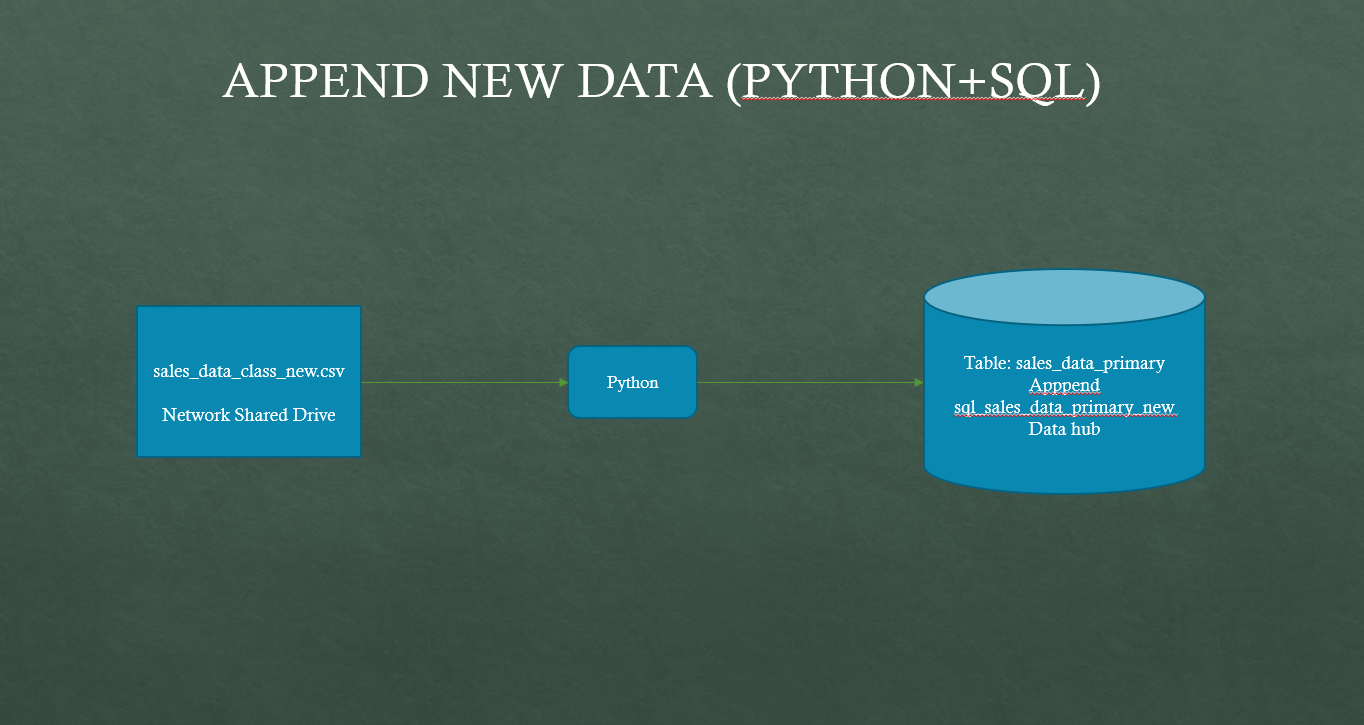

In [29]:
# from datetime import datetime
# dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y')


'''get new data'''
df_sales_p_new=pd.read_csv(file_path+'data/user_table_new.csv', index_col=False)


'''export new data into datahub'''
df_sales_p_new.to_sql("user_table_new", engine_datahub,if_exists='replace',index=False) 

In [30]:
#append new data to historical data

server = 'localhost\SQLEXPRESS' 
database = 'datahub' 
username = 'sa' 
password = 'user1' 
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

sql='''

DROP TABLE IF EXISTS #temp1

select * into #temp1
from (
select * from [dbo].[sql_user_table]
union 
select * from [dbo].[sql_user_table]) a

drop table if EXISTS [dbo].[sql_user_table]

select * into [dbo].[sql_user_table]
from #temp1

'''

cursor.execute(sql)
cnxn.commit()
cursor.close()